# USAGE EXAMPLES FOR SIMPLESEDML

**To do**
1. Example of stochastic time course
2. Parameter scans: one-step, steady-state
3. Example of mixing low-level API and task API.

This notebook provides examples of using ``SimpleSBML``.

The initial emphasize is on time course simulations. A ``SingleModelTimeCourse`` object has one required parameter, the model. This can be an Antimony or SBML string or file or a URL. There are optional parameters related to the simulation and changing values of the paramters of the model. It has the following methods:
* ``getSEDML``
* ``getPhraSEDML``
* ``execute``: returns a ``DataFrame`` and a plot of the variables specified in the constructor.
* ``makeOMEXFile`` creates an omex file

A ``MultipleModelTimeCourseObject`` has the same arguments as for ``SingleModelTimeCourse`` except that the one required argument is a list of models. It has the same methods as well. The only difference is that there is one plot for each variable specified in the constructor with a curve for each model.

Some use cases are:
1. Iteratively develop SEDML by use execute, and then generate desired SEDML.
2. Generate PhraSEDML, edit it, and then generate SEDML from these edits.

In [1]:
# Handle execution locally and in Colab
try:
    import SimpleSEDML as ss
except:
    !pip install SimpleSEDML
    import SimpleSEDML as ss
import pandas as pd

/Users/jlheller/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Collect paths of files creates
MODEL_SOURCES = []

# Model

In [3]:
MODEL_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1

    S1 is "species1"
    S2 is "species2"
end
'''

In [4]:
MODEL2_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S1; k3*S3
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
    k3 = 0.1
end
'''

# Use Case 1: Single model with default arguments

In [5]:
?ss.makeSingleModelTimeCourse

Init signature:
ss.makeSingleModelTimeCourse(
    model_ref: str,
    project_id: Optional[str] = None,
    ref_type: Optional[str] = None,
    simulation_type: str = 'uniform',
    project_dir: Optional[str] = None,
    display_variables: Optional[List[str]] = None,
    start: float = 0,
    end: float = 5,
    num_step: Optional[int] = None,
    num_point: Optional[int] = None,
    title: Optional[str] = None,
    algorithm: Optional[str] = None,
    is_plot: bool = True,
    model_parameter_dct: Optional[dict] = None,
)
Docstring:      Class to create a time course simulation for a single model
Init docstring:
Creates a time course simulation

Args:
    model_ref: reference to the model
    project_id: ID of the project, if None, uses the default project ID
    ref_type: type of the reference (e.g. "sbml_str", "ant_str", "sbml_file", "ant_file", "sbml_url")
    simulation_type: type of the simulation
            (e.g., "uniform", "uniform_stochastic", "steadystate", "onestep")
    p

In [6]:
smtc = ss.makeSingleModelTimeCourse(MODEL_ANT, title="My Plot", num_point=100)

In [7]:
print(smtc.getPhraSEDML())

project_model = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmplwtywfa1/project_model.xml" 
project_sim = simulate uniform(0, 5.0, 99)
project_sim.algorithm = CVODE
project_task = run project_sim on project_model
report time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


In [8]:
print(smtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="project_model" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmplwtywfa1/project_model.xml"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="project_sim" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="99">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="project_task" modelReference="project_model" simulationReference="project_sim"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
   

We can also look at the PhraSED-ML that gets generated by changing the object that gets returned.

In [9]:
print(smtc.getPhraSEDML())

project_model = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmplwtywfa1/project_model.xml" 
project_sim = simulate uniform(0, 5.0, 99)
project_sim.algorithm = CVODE
project_task = run project_sim on project_model
report time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


And we can execute the SEDML, getting both a plot and a DataFrame of time course values.

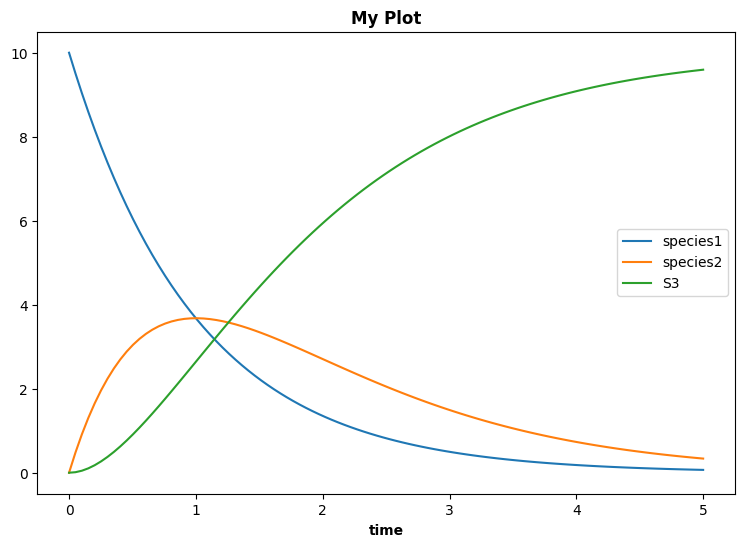

In [10]:
df = smtc.execute()

In [11]:
df.head()

,time,S1,S2,S3
0,0.000000,10.000000,0.000000,0.000000
1,0.050505,9.507491,0.480176,0.012332
2,0.101010,9.039239,0.913054,0.047707
3,0.151515,8.594049,1.302129,0.103823
4,0.202020,8.170784,1.650664,0.178552


In [12]:
# Eliminate the temporary files
smtc.cleanUp()

# Use Case 2: Single model with non-default arguments

In [13]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"

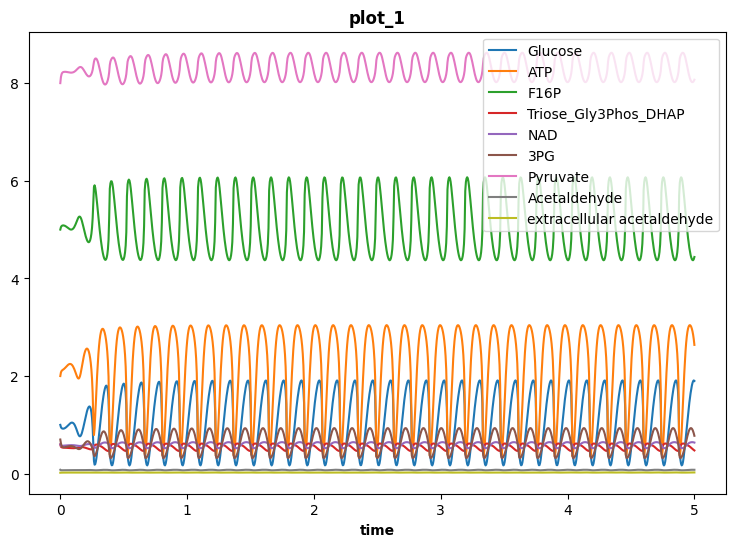

In [14]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, num_point=1000)
_ = smtc.execute()

In [15]:
ss.getModelInformation(WOLF_URL)

Model: Wolf2000_Glycolytic_Oscillations
Parameters: {'k0': 50.0, 'k1': 550.0, 'k2': 9.8, 'k31': 323.8, 'k33': 57823.1, 'k32': 76411.1, 'k34': 23.7, 'k4': 80.0, 'k5': 9.7, 'k6': 2000.0, 'k7': 28.0, 'k8': 85.7, 'k9': 80.0, 'k10': 375.0, 'atot': 4.0, 'ntot': 1.0, 'n': 4.0, 'ki': 1.0}
Floating Species: {'s1': 1.0, 'at': 2.0, 's2': 5.0, 's3': 0.6, 'na': 0.6, 's4': 0.7, 's5': 8.0, 's6': 0.08, 's6o': 0.02}
Boundary Species: {}
Number of Reactions: 11
Number of Species: 9

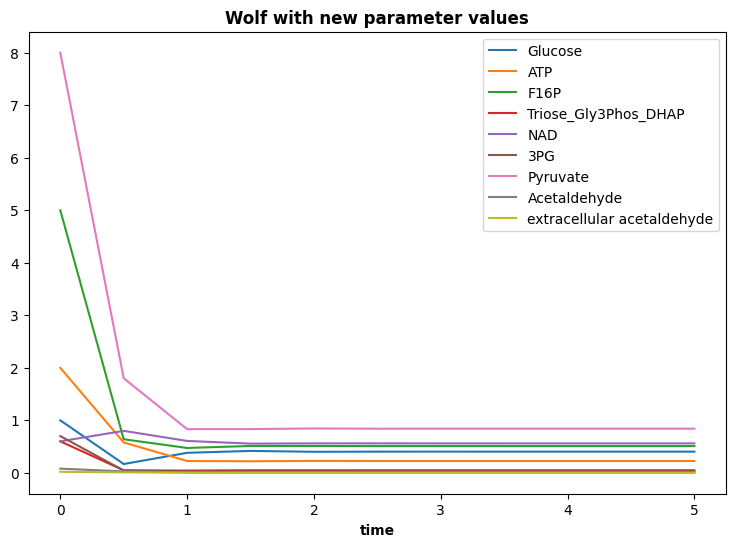

In [16]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, model_parameter_dct=dict(k0=5, k1=55),
            title="Wolf with new parameter values")
df = smtc.execute()

In [17]:
df.head()

,time,s1,at,s2,s3,na,s4,s5,s6,s6o
0,0.0,1.000000,2.000000,5.000000,0.600000,0.600000,0.700000,8.000000,0.080000,0.020000
1,0.5,0.167970,0.579162,0.639675,0.047800,0.799205,0.043673,1.801447,0.026906,0.008861
2,1.0,0.381272,0.225642,0.473636,0.042924,0.607620,0.025901,0.832152,0.007774,0.002500
3,1.5,0.417602,0.220384,0.511794,0.049333,0.556435,0.026954,0.832856,0.007070,0.002255
4,2.0,0.400847,0.227533,0.511717,0.049070,0.561399,0.027128,0.845115,0.007238,0.002310


In [18]:
smtc.cleanUp()

# Use Case 3: Comparing the time course simulation of multiple models

When comparing the time course simulation of multiple models, we want to compare selected **display variables** from the models, either in plots or in a DataFrame. This is done with the  ``MultipleModelTimeCourse`` object.

In [19]:
mmtc = ss.makeMultipleModelTimeCourse([MODEL_ANT, MODEL2_ANT], model_parameter_dct=dict(k1=10), num_point=100)

In [20]:
print(mmtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model0" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model0.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <un

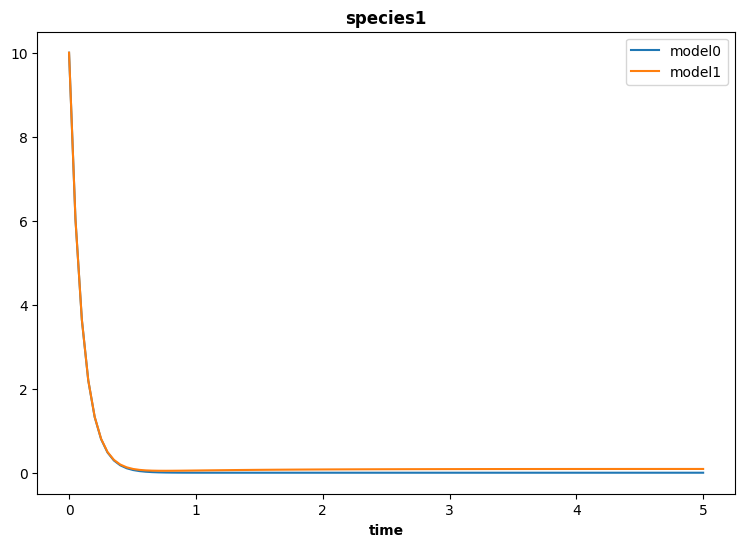

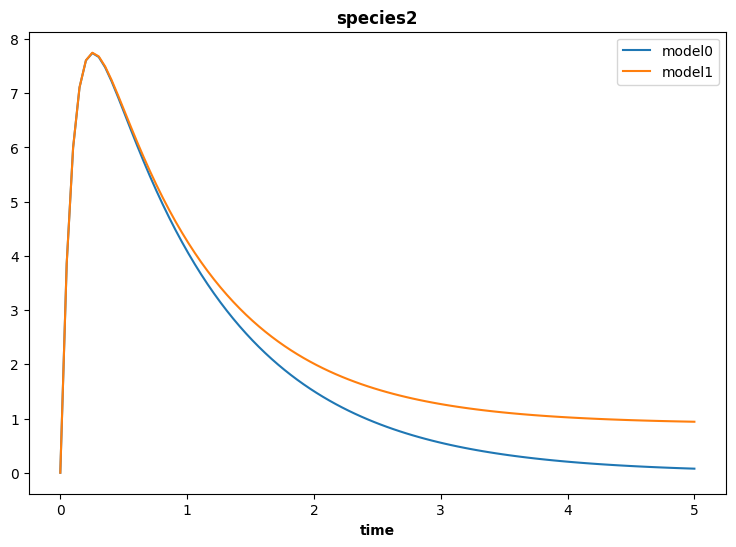

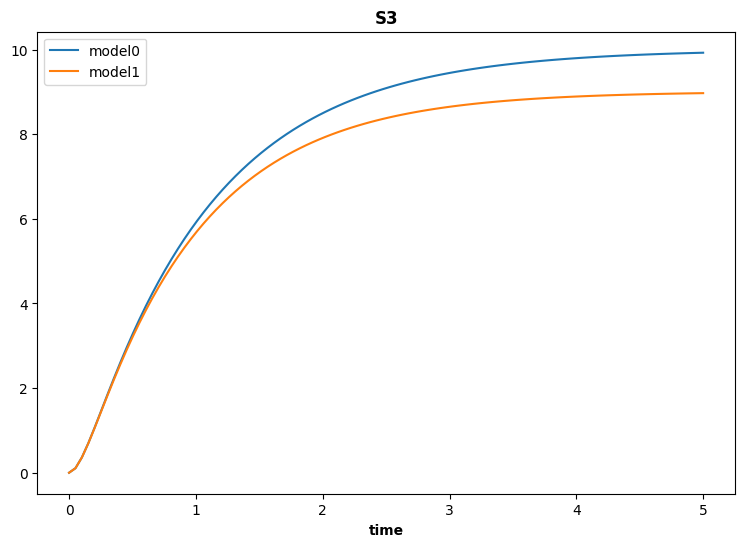

,tmodel0.time,tmodel0.S1,tmodel1.S1,tmodel0.S2,tmodel1.S2,tmodel0.S3,tmodel1.S3
0,0.000000,1.000000e+01,10.000000,0.000000,0.000000,0.000000,0.000000
1,0.050505,6.034751e+00,6.034912,3.858601,3.858627,0.106649,0.106461
2,0.101010,3.641824e+00,3.642859,5.997128,5.997406,0.361048,0.359735
3,0.151515,2.197752e+00,2.200499,7.106996,7.108161,0.695252,0.691340
4,0.202020,1.326293e+00,1.331475,7.604990,7.608033,1.068717,1.060492
...,...,...,...,...,...,...,...
95,4.797980,-6.086515e-14,0.089539,0.091627,0.950471,9.908373,8.959990
96,4.848485,2.622485e-14,0.089569,0.087114,0.947766,9.912886,8.962665
97,4.898990,5.909949e-14,0.089597,0.082824,0.945208,9.917176,8.965194
98,4.949495,7.401011e-14,0.089624,0.078745,0.942790,9.921255,8.967585


In [21]:
mmtc.execute()

In [22]:
mmtc.model_dct

{'model0': <SimpleSEDML.model.Model at 0x177f9d2b0>,
 'model1': <SimpleSEDML.model.Model at 0x177e83fd0>,
 'model2': <SimpleSEDML.model.Model at 0x177f646a0>,
 'model3': <SimpleSEDML.model.Model at 0x177f64190>,
 'model4': <SimpleSEDML.model.Model at 0x177f67910>,
 'model5': <SimpleSEDML.model.Model at 0x177f67e80>}

In [23]:
print(mmtc.getPhraSEDML())

model0 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model0.xml"  with k1 = 10
model1 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model1.xml"  with k1 = 10
model2 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model2.xml"  with k1 = 10
model3 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model3.xml"  with k1 = 10
model4 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model4.xml"  with k1 = 10
model5 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model5.xml"  with k1 = 10
model6 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model6.xml"  with k1 = 10
model7 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpue0duksy/model7.xml"  with k1 = 10
mmtc_sim1 = simulate uniform(0.0, 5.0, 99)
mmtc_sim1.algorithm = CVODE
tmodel0 = run mmtc_sim1 on model0
tmodel1 = run mmtc_sim1 on model1
tmodel2 = run mmtc_sim1 on model2
tmo

## Creating an OMEX file

We can create an OMEX file for this experiment.

In [24]:
omex_path, _ = mmtc.makeOMEXFile()
omex_path

'/Users/jlheller/home/Technical/repos/SimpleSEDML/examples/project.omex'

In [25]:
# We can examine the content of the OMEX file.
!unzip -l project.omex

Archive:  project.omex
  Length      Date    Time    Name
---------  ---------- -----   ----
     1096  06-02-2025 15:18   metadata.rdf
     2262  06-02-2025 15:18   model0.xml
     2845  06-02-2025 15:18   model1.xml
     2262  06-02-2025 15:18   model2.xml
     2845  06-02-2025 15:18   model3.xml
     2262  06-02-2025 15:18   model4.xml
     2845  06-02-2025 15:18   model5.xml
     2262  06-02-2025 15:18   model6.xml
     2845  06-02-2025 15:18   model7.xml
     2262  06-02-2025 15:18   model8.xml
     2845  06-02-2025 15:18   model9.xml
     8855  06-02-2025 15:18   project.sedml
     1464  06-02-2025 15:18   manifest.xml
---------                     -------
    36950                     13 files


In [26]:
mmtc.cleanUp()

# Case 4: Parameter Scans: onestep and steadystate

## Single Model Parameter Scan

m_Wolf = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpe1ypjl3d/m_Wolf.xml" 
s_Wolf = simulate onestep(10)
st_Wolf = run s_Wolf on m_Wolf
rt_Wolf = repeat st_Wolf for k1 in [50, 550, 5000], reset=true
report rt_Wolf.k1, rt_Wolf.at, rt_Wolf.na
plot "Wolf" rt_Wolf.k1 vs rt_Wolf.at, rt_Wolf.na


/Users/jlheller/home/Technical/repos/SimpleSEDML/src/SimpleSEDML/simple_sedml.py:374: UserWarning:

Reports only generate data for the last repeated task.



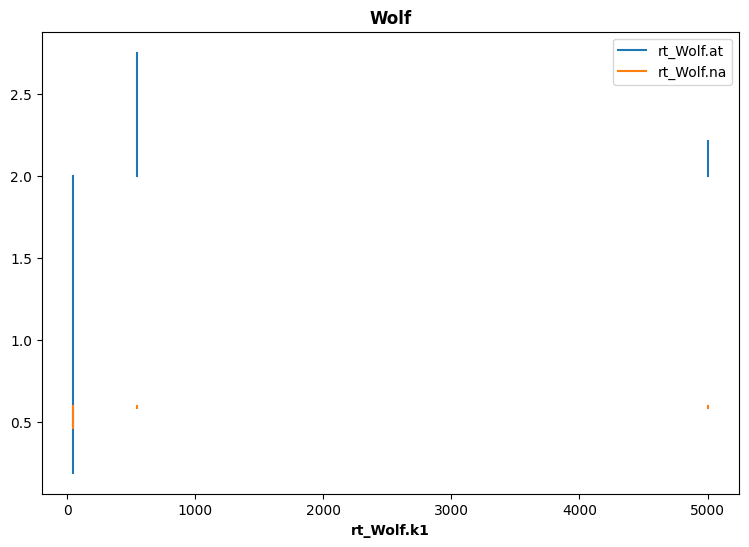

In [27]:
smps = ss.makeSingleModelParameterScan(WOLF_URL, simulation_type="onestep",
                                       project_id="Wolf", title="Wolf",
        time_interval=10, display_variables=["at", "na"], scan_parameter_dct=dict(k1=[50, 550, 5000]))
print(smps.getPhraSEDML())
_ = smps.execute()

## Multiple Model Parameter Scan

In [28]:
mmps = ss.makeMultipleModelParameterScan([], simulation_type="onestep",
                                       project_id="Wolf", title="Wolf",
        time_interval=10, display_variables=['at', 'na'], scan_parameter_df=pd.DataFrame(dict(k1=[50, 550, 5000])))


In [29]:
_ = mmps.addModel("k0_1", WOLF_URL, parameter_dct=dict(k0=1))
_ = mmps.addModel("k0_25", WOLF_URL, parameter_dct=dict(k0=25))
_ = mmps.addModel("k0_600", WOLF_URL, parameter_dct=dict(k0=600))
_ = mmps.addModel("k0_6000", WOLF_URL, parameter_dct=dict(k0=6000))

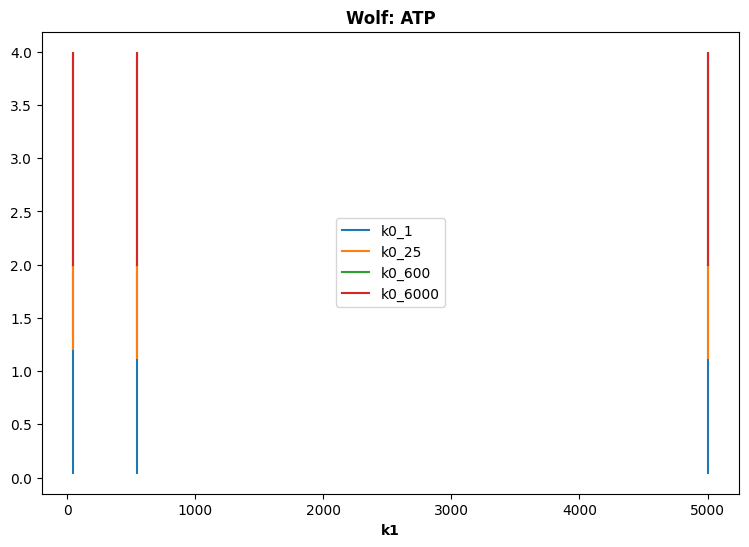

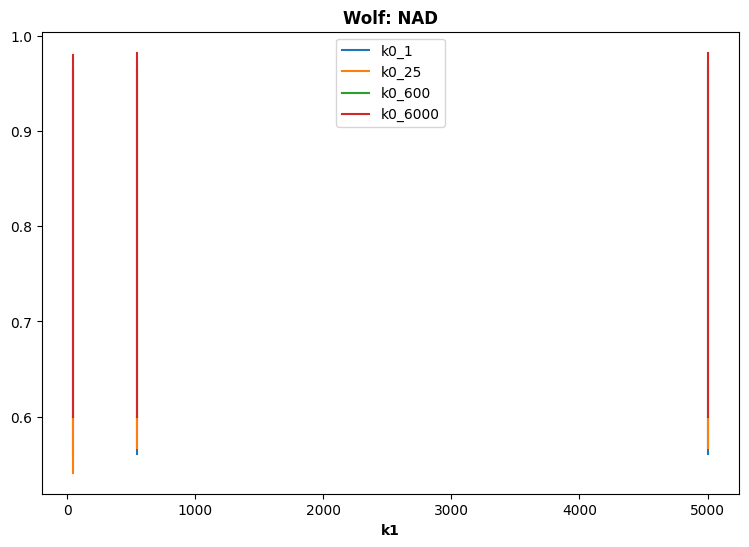

In [30]:
#print(smps.getPhraSEDML())
_ = mmps.execute()

# Under construction: Compare several parameters at steady state for a single model

# Under construction: Compare stochastic simulations

# Under construction: Repeated Tasks

At present, the Tellurium execution of SED-ML only provides access to the last report for repeated tasks.

In [31]:
# Make DataFrame of changes to model parameters
parameter_df = pd.DataFrame(dict(k1=[1, 3], k2=[1, 3]))

/Users/jlheller/home/Technical/repos/SimpleSEDML/src/SimpleSEDML/simple_sedml.py:374: UserWarning:

Reports only generate data for the last repeated task.



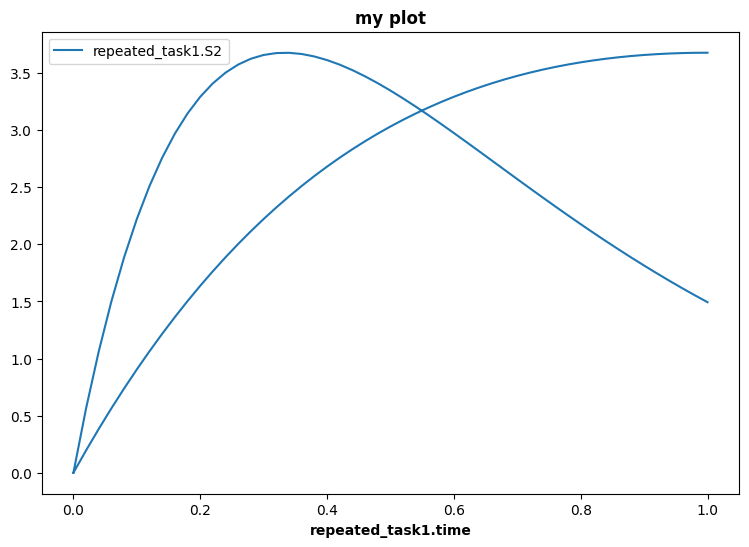

In [32]:
ssed = ss.SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, parameter_dct=dict(k1=3), ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addRepeatedTask("repeated_task1", "task1", parameter_df=parameter_df)
ssed.addReport("task1.time", "task1.S1", "task1.S2", "task1.S3")
ssed.addPlot("repeated_task1.time", "repeated_task1.S2", title="my plot")
result_df = ssed.execute()

In [33]:
print(ssed.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpm95zng6e/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="3"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="1" numberOfSteps="50">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="repeated_task1" range="vect

In [34]:
ssed.cleanUp()

# Cleanup

In [35]:
import os
EXAMPLE_REMOVE_FILES = ["simple_sedml_plot.png", "project.omex", "project.omex"]
example_dir = os.getcwd()
remove_files = [os.path.join(example_dir, f) for f in EXAMPLE_REMOVE_FILES]
remove_files.extend(MODEL_SOURCES)
for ffile in remove_files:
    if os.path.isfile(ffile):
        os.remove(ffile)